In [ ]:
# Hybrid fitness

平均値を /Users/ryamaguchi/Desktop/average_results_FGM_fitness_mig.csv に保存しました。
平均値を /Users/ryamaguchi/Desktop/average_results_FGM_fitness_firstmig.csv に保存しました。
平均値を /Users/ryamaguchi/Desktop/average_results_FGM_fitness_secondmig.csv に保存しました。


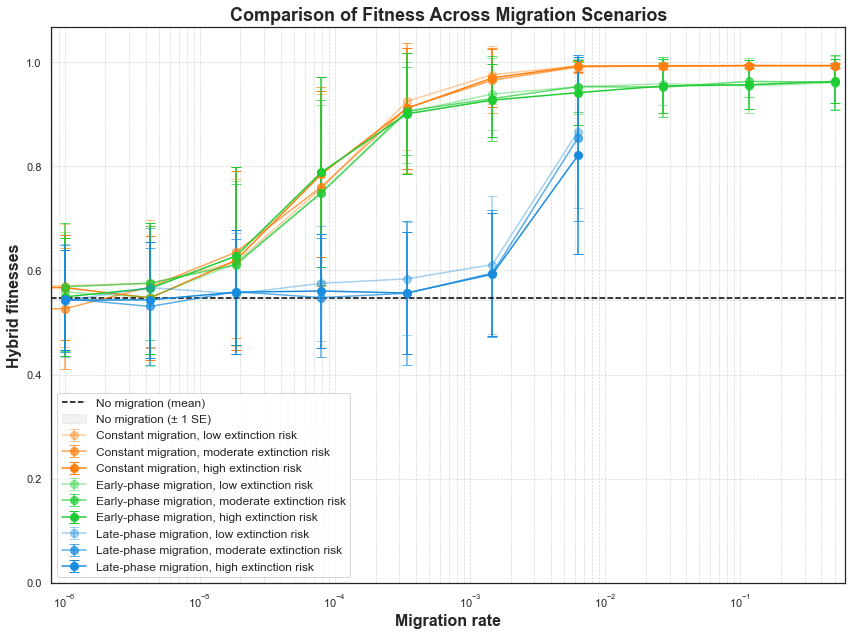

統合プロットを /Users/ryamaguchi/Desktop/combined_fitness_plot_with_std.pdf に保存しました。


In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
import csv
import seaborn as sns

# Graph saving settings
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42  # Save plot as .svg file for Adobe Illustrator editing

# Apply seaborn style for a polished look
sns.set(style="white")

# Output folder
output_folder = os.path.expanduser("~/Desktop/")
os.makedirs(output_folder, exist_ok=True)

# Directory definitions
dirs = {
    'FGM_fitness_mig={}_g={}_run={}_p3.dat': os.path.expanduser("~/Desktop/SLiM_pop"),
    'FGM_fitness_firstmig=0_mig={}_g={}_run={}_p3.dat': os.path.expanduser("~/Desktop/SLiM_pop_2"),
    'FGM_fitness_secondmig=0_mig={}_g={}_run={}_p3.dat': os.path.expanduser("~/Desktop/SLiM_pop_2"),
}

# List of mig values (sorted in ascending order)
mig_values = [
    "0.0", "1.0e-06", "4.29753e-06", "1.84688e-05", "7.93701e-05", "0.000341095", "0.00146587", "0.00629961", "0.0270727", "0.116346", "0.5"
]

# List of g values
g_values = ["1.2", "1.1", "1.08"]

# File templates
file_templates = list(dirs.keys())

# Dictionary to store averages
average_results = {template: {g: {mig: [] for mig in mig_values} for g in g_values} for template in file_templates}

def load_and_compute_average(file_path):
    """
    Load data from a specified file and compute the average.
    """
    try:
        with open(file_path, 'r') as file:
            data = file.read()
        values = np.array(data.split(), dtype=float)
        return np.mean(values)
    except FileNotFoundError:
        return None
    except ValueError as e:
        print(f"Invalid data in file {file_path}: {e}")
        return None

def find_existing_files(directory, template, mig, g):
    """
    Search for up to 100 existing files in a specified directory and template.
    """
    existing_files = []
    run_number = 0
    while len(existing_files) < 100:
        file_path = os.path.join(directory, template.format(mig, g, run_number))
        if os.path.exists(file_path):
            existing_files.append(run_number)
        run_number += 1
        if run_number > 1000:  # Prevent infinite loops
            break
    return existing_files

# Loop through each template, g, and mig
for template, directory in dirs.items():
    for g in g_values:
        for mig in mig_values:
            existing_runs = find_existing_files(directory, template, mig, g)
            for run_number in existing_runs:
                if mig == "0.0" and template in [
                    'FGM_fitness_firstmig=0_mig={}_g={}_run={}_p3.dat',
                    'FGM_fitness_secondmig=0_mig={}_g={}_run={}_p3.dat']:
                    continue  # Use 'FGM_fitness_mig={}_g={}_run={}_p3.dat' for mig=0.0

                file_path = os.path.join(directory, template.format(mig, g, run_number))
                average = load_and_compute_average(file_path)
                if average is not None:
                    average_results[template][g][mig].append(average)

# Save results to CSV files for each template
for template in file_templates:
    output_csv = os.path.join(output_folder, f'average_results_{template.split("=")[0]}.csv')
    with open(output_csv, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["g", "mig", "runNumber", "average_value"])
        for g in g_values:
            for mig in mig_values:
                for run_number, avg in enumerate(average_results[template][g][mig]):
                    writer.writerow([g, mig, run_number, avg])
    print(f"Saved averages to {output_csv}.")

# Combine all plots into one
plt.figure(figsize=(12, 9))
colors = ['#ff7f0e', '#1fcc33', '#188cde']
labels = ['Constant migration', 'Early-phase migration', 'Late-phase migration']
shades = {
    "1.2": 0.4,  # light
    "1.1": 0.7,  # moderate
    "1.08": 1.0  # dark
}

for idx, template in enumerate(['FGM_fitness_mig={}_g={}_run={}_p3.dat', 'FGM_fitness_secondmig=0_mig={}_g={}_run={}_p3.dat', 'FGM_fitness_firstmig=0_mig={}_g={}_run={}_p3.dat']):
    for g in g_values:
        m_values_new = [float(m.replace('e', 'E')) for m in mig_values]
        m_all_average_values = [
            np.mean([val for val in average_results[template][g][mig] if val > 0]) if any(val > 0 for val in average_results[template][g][mig]) else None for mig in mig_values
        ]
        m_std_values = [
            np.std([val for val in average_results[template][g][mig] if val > 0]) if any(val > 0 for val in average_results[template][g][mig]) else None for mig in mig_values
        ]

        # Plot averages and standard deviations
        m_values_filtered = [(m, avg, std) for m, avg, std in zip(m_values_new, m_all_average_values, m_std_values) if avg is not None]
        if m_values_filtered:
            m_values_filtered, m_all_average_values_filtered, m_std_values_filtered = zip(*m_values_filtered)
            risk_label = {
                "1.2": "low extinction risk",
                "1.1": "moderate extinction risk",
                "1.08": "high extinction risk"
            }
            shade_alpha = shades[g]
            plt.errorbar(m_values_filtered, m_all_average_values_filtered, yerr=m_std_values_filtered, fmt='o-', color=colors[idx], alpha=shade_alpha, label=f'{labels[idx]}, {risk_label[g]}', markersize=8, capsize=5)

# Average and standard deviation for mig=0.0 in FGM_fitness_mig={}_g={}_run={}_p3.dat
mig_0_mean = np.mean([np.mean([val for val in average_results['FGM_fitness_mig={}_g={}_run={}_p3.dat'][g]['0.0'] if val > 0]) for g in g_values if any(val > 0 for val in average_results['FGM_fitness_mig={}_g={}_run={}_p3.dat'][g]['0.0'])])
mig_0_std = np.std([np.mean([val for val in average_results['FGM_fitness_mig={}_g={}_run={}_p3.dat'][g]['0.0'] if val > 0]) for g in g_values if any(val > 0 for val in average_results['FGM_fitness_mig={}_g={}_run={}_p3.dat'][g]['0.0'])])
plt.axhline(y=mig_0_mean, color='black', linestyle='--', label=f'No migration (mean)')
plt.fill_between([min(m_values_new), max(m_values_new)],
                 mig_0_mean - mig_0_std,
                 mig_0_mean + mig_0_std,
                 color='black', alpha=0.05, label='No migration (± 1 SE)')

# Graph settings
plt.xscale('log')
plt.xlim(10**(-6.1), 0.6)
plt.ylim(0, None)
plt.xlabel('Migration rate', fontsize=16, fontweight='bold')
plt.ylabel('Hybrid fitnesses', fontsize=16, fontweight='bold')
plt.grid(visible=True, which="both", linestyle="--", linewidth=0.7, alpha=0.8)
plt.title("Comparison of Fitness Across Migration Scenarios", fontsize=18, fontweight='bold')
plt.legend(fontsize=12)
plt.tight_layout()

# Save plot
plot_file = os.path.join(output_folder, 'combined_fitness_plot_with_std.pdf')
plt.savefig(plot_file, format='pdf')
plt.show()
print(f"Saved combined plot to {plot_file}.")
